In [1]:
import joblib
import os
import pandas as pd
import matplotlib.pyplot as plt

file_path = os.path.join("joblibdata", "docking_result_dataframe.joblib")
chemical_df = joblib.load(file_path)

In [2]:
# Cell 4: PCA → tSNE → DBSCAN clustering + visualization
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ────────────────
# PARAMETERS
# ────────────────
n_pca_components   = 33     # 80%: 33 components
tsne_perplexity    = 30      # perplexity for tSNE

# ────────────────
# 1. PCA on the full feature matrix
# ────────────────
pca = PCA(n_components=n_pca_components, random_state=42)
X_pca = pca.fit_transform(chemical_df.values)
explained = pca.explained_variance_ratio_.sum()
print(f"Variance explained by PCA ({n_pca_components} components): {explained:.2%}")

# ────────────────
# 2. tSNE embedding of PCA output
# ────────────────
tsne = TSNE( n_components=2,perplexity=tsne_perplexity, random_state=42 )
X_tsne = tsne.fit_transform(X_pca)

Variance explained by PCA (33 components): 80.07%


Number of clusters found: 636
Number of noise/unclustered points: 962


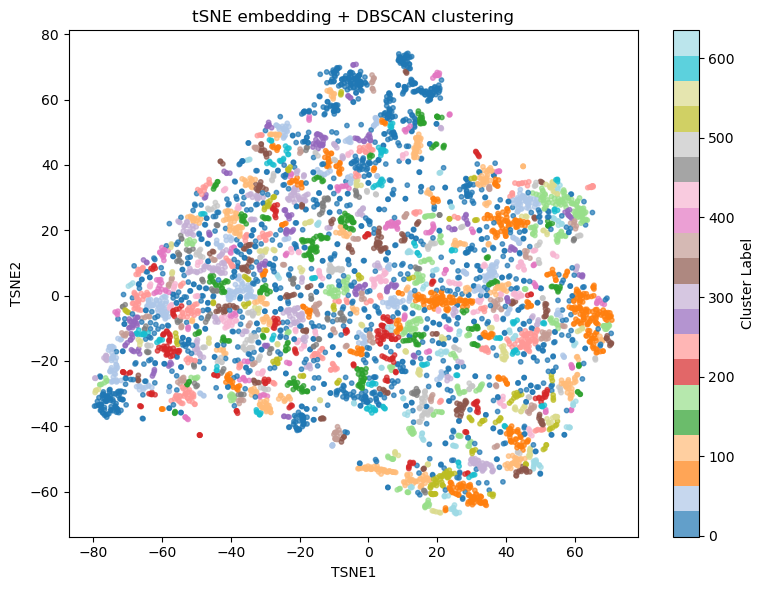

In [3]:
# ────────────────
# PARAMETERS
# ────────────────
dbscan_eps         = 1.2     # eps parameter for DBSCAN
dbscan_min_samp    = 3       # min_samples parameter for DBSCAN


# ────────────────
# 3. DBSCAN clustering on the tSNE embedding
# ────────────────
clusterer = DBSCAN(eps=dbscan_eps, min_samples=dbscan_min_samp)
labels = clusterer.fit_predict(X_tsne)

# ────────────────
# 4. Build DataFrame of embedding + cluster labels
# ────────────────
df_cluster = pd.DataFrame( X_tsne, columns=['TSNE1', 'TSNE2'], index=chemical_df.index )
df_cluster['cluster'] = labels

# ────────────────
# 5. Summary statistics
# ────────────────
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise    = list(labels).count(-1)
print(f"Number of clusters found: {n_clusters}")
print(f"Number of noise/unclustered points: {n_noise}")

# ────────────────
# 6. Visualization
# ────────────────
plt.figure(figsize=(8, 6))
scatter = plt.scatter( df_cluster['TSNE1'], df_cluster['TSNE2'], c=df_cluster['cluster'], cmap='tab20', s=10, alpha=0.7)
plt.title('tSNE embedding + DBSCAN clustering')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.colorbar(scatter, label='Cluster Label')
plt.tight_layout()
plt.show()

In [4]:
target_col = ["SAMPLE_NAME", "std_SMILES", 
              'AR agonist / ar-bla-agonist-p1', 'AR antagonist / ar-bla-antagonist-p1',
              'CAR antagonist / car-antagonist-p1',
              'ER agonist / er-bla-agonist-p2','ER antagonist / er-bla-antagonist-p1', 
              'ERB antagonist / erb-bla-antagonist-p1', 'ERB agonist / erb-bla-p1', 'ERB antagonist / erb-bla-p1',
              'FXR agonist / fxr-bla-agonist-p2', 'FXR antagonist / fxr-bla-antagonist-p1',
              'GR agonist / gr-hela-bla-agonist-p1', 'GR antagonist / gr-hela-bla-antagonist-p1',
              'PPARD agonist / ppard-bla-agonist-p1', 'PPARD antagonist / ppard-bla-antagonist-p1',
              "PPARG agonist / pparg-bla-agonist-p1", "PPARG antagonist / pparg-bla-antagonist-p1",
              'PR agonist / pr-bla-agonist-p1', 'PR antagonist / pr-bla-antagonist-p1',
              'PXR agonist / pxr-p1', 'PXR antagonist / pxr-p1',
              'RAR agonist / rar-agonist-p1', 'RAR antagonist / rar-antagonist-p2',
              'ROR antagonist / ror-cho-antagonist-p1',
              'RXR agonist / rxr-bla-agonist-p1',
              'VDR agonist / vdr-bla-agonist-p1', 'VDR antagonist / vdr-bla-antagonist-p1'
              ]
df_ligand_info = pd.read_excel("AutodockGPU/LigandInfo.xlsx", index_col = -2)[target_col]

assay_info_table = []
selected_assays = []
for col in df_ligand_info.columns[2:]:
    # count df_ligand_info[col].value_counts()
    counts = df_ligand_info[col].value_counts()
    active_count, inactive_count = counts.get("Active", 0), counts.get("Inactive", 0)
    
    if active_count >= 50:
        selected_assays.append(col)
        
    assay_info_table.append({
        "Assay name": col.split("/")[1].strip(),
        "Assay end point": col.split("/")[0].strip(),
        "# of Active": active_count,
        "# of Inactive": inactive_count,
        "Inclusion/Exclusion": "Included" if active_count >= 50 else "Excluded",
    })
assay_info_table = pd.DataFrame(assay_info_table)
assay_info_table

,Assay name,Assay end point,# of Active,# of Inactive,Inclusion/Exclusion
0,ar-bla-agonist-p1,AR agonist,207,6200,Included
1,ar-bla-antagonist-p1,AR antagonist,365,5380,Included
2,car-antagonist-p1,CAR antagonist,131,4665,Included
3,er-bla-agonist-p2,ER agonist,331,6272,Included
4,er-bla-antagonist-p1,ER antagonist,241,5517,Included
5,erb-bla-antagonist-p1,ERB antagonist,381,5226,Included
6,erb-bla-p1,ERB agonist,97,6407,Included
7,erb-bla-p1,ERB antagonist,0,6415,Excluded
8,fxr-bla-agonist-p2,FXR agonist,92,6103,Included
9,fxr-bla-antagonist-p1,FXR antagonist,156,5490,Included


In [5]:
# Cell 6: enrichment analysis per cluster (updated)
from scipy.stats import chi2_contingency
from statsmodels.stats.multitest import multipletests
import numpy as np

# 1. Merge clustering output with ligand annotations
df = df_cluster.join(df_ligand_info[["SAMPLE_NAME", "std_SMILES"] + selected_assays])

# 2. Shorten column names for readability
df.rename(columns={
    assay: assay.split("/")[0].strip() for assay in selected_assays
    }, inplace=True)

# 3. Define the (short) activity columns to test
activity_cols = [assay.split("/")[0].strip() for assay in selected_assays]
clusters = sorted(df['cluster'].unique())

# 4. Compute raw p-values, %Active, and adjusted p-values for each (cluster, assay)
cluster_stats = {col: {} for col in activity_cols}

for col in activity_cols:
    raw_p = []
    for cl in clusters:
        in_cl = df['cluster'] == cl
        act   = df[col] == "Active"
        
        # contingency counts
        a = int((in_cl & act).sum())        # Active in cluster
        b = int((in_cl & ~act).sum())       # Inactive in cluster
        c = int((~in_cl & act).sum())       # Active outside
        d = int((~in_cl & ~act).sum())      # Inactive outside
        
        # chi-square test
        _, p, _, _ = chi2_contingency([[a, b], [c, d]])
        raw_p.append(p)
        
        # % Active in this cluster
        pct = a / (a + b) * 100 if (a + b) > 0 else np.nan
        
        cluster_stats[col][cl] = {
            'raw_p':     p,
            'pct_active': pct
        }
    
    # adjust across clusters for this assay
    _, adj_p, _, _ = multipletests(raw_p, method='fdr_bh')
    for cl, p_adj in zip(clusters, adj_p):
        cluster_stats[col][cl]['adj_p'] = p_adj

# 5. Map cluster‐level stats back onto each compound row
for col in activity_cols:
    df[f"%_active_{col}"] = df['cluster'].map(
        {cl: cluster_stats[col][cl]['pct_active'] for cl in clusters}
    )
    df[f"raw_pval_{col}"]   = df['cluster'].map(
        {cl: cluster_stats[col][cl]['raw_p'] for cl in clusters}
    )
    df[f"adj_pval_{col}"]   = df['cluster'].map(
        {cl: cluster_stats[col][cl]['adj_p'] for cl in clusters}
    )

# 6. Your final result DataFrame
result_df = df.copy()
result_df.to_csv("clustering_result.csv")